In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.stats import chi2
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [2]:
class AdaBoost:
    def __init__(self, B, base_learner_factory=None):
        self.B = B
        self.base_learner_factory = base_learner_factory
        if base_learner_factory is None:
            def create_stump():
                model = DecisionTreeClassifier(max_depth=1)
                return model
            self.base_learner_factory = create_stump
        self.ensemble = None
    
    def predict(self, X, num_ensembles=None):
        if num_ensembles == None:
            num_ensembles = len(self.ensemble)
        num_ensembles = max(0, num_ensembles)
        num_ensembles = min(num_ensembles, len(self.ensemble))
        ensemble = self.ensemble[:num_ensembles]

        y_pred = []
        for i in range(len(ensemble)):
            y_pred_i = self.ensemble[i][0].predict(X)
            y_pred.append(y_pred_i)
        y_pred = np.vstack(y_pred).T

        betas = np.array([x[1] for x in ensemble])
        classes = np.unique(y_pred)
        y_cls = []
        for cls in classes:
            y_cls_val = np.sum(
                (y_pred == cls).astype(int) * np.log(1 / betas), 
                axis=1
                )
            y_cls.append(y_cls_val)
        y_cls = np.vstack(y_cls)
        
        y_pred = classes[np.argmax(y_cls, axis=0)]
        return y_pred

    def fit(self, X, y):
        self.ensemble = []
        w = np.ones(len(y)) / len(y)
        for i in range(self.B):
            bl = self.base_learner_factory()
            bl.fit(X, y, w)
            y_train_pred = bl.predict(X)
            fail_idx = y != y_train_pred
            eps = w[fail_idx].sum()
            beta = eps / (1 - eps)
            self.ensemble.append((bl, beta))
            w[~fail_idx] *= beta
            w /= w.sum()

In [3]:
df = 10
n = 12000

X_artificial = np.pow(np.random.normal(size=(n, df)), 2)
chi2_median = chi2.ppf(0.5, df)
y_artificial = (X_artificial.sum(axis=1) > chi2_median).astype(int) #* 2 - 1

(
    X_artificial_train, 
    X_artificial_test, 
    y_artificial_train, 
    y_artificial_test
) = train_test_split(
    X_artificial, 
    y_artificial, 
    shuffle=True, 
    train_size=10000
    )

In [4]:
encoder = OneHotEncoder(sparse_output=False)
y_encoder = LabelEncoder()
df_math = pd.read_csv(
    os.path.join('student+performance', 'student', 'student-mat.csv'),
    sep=';'
    )
df_math = df_math[df_math.G1 > 5]
df_math.drop(columns=['G2', 'G3'], inplace=True)
str_cols = df_math.columns[df_math.dtypes == 'object']
encoder.fit(df_math[str_cols])
encoded_data = encoder.transform(df_math[str_cols])
df_math.drop(columns=str_cols, inplace=True)

X_real, y_real = df_math.drop(columns='G1').to_numpy(), df_math['G1'].to_numpy()
X_real = np.concat([X_real, encoded_data], axis=1)
# 1 is good performance of student, 0 is bad performance
y_real = (y_real > round(np.median(y_real))).astype(int)
y_real = y_encoder.fit_transform(y_real)

In [ ]:
encoder = OneHotEncoder(sparse_output=False)
y_encoder = LabelEncoder()
df_math = pd.read_csv(
    os.path.join('student+performance', 'student', 'student-mat.csv'),
    sep=';'
    )
df_math = df_math[df_math.G1 > 5]
df_math.drop(columns=['G2', 'G3'], inplace=True)

str_cols = df_math.columns[df_math.dtypes == 'object']
for str_col in str_cols:
    dummy_encoder = LabelEncoder()
    df_math[str_col] = dummy_encoder.fit_transform(df_math[str_col])

X_real, y_real = df_math.drop(columns='G1').to_numpy(), df_math['G1'].to_numpy()
X_real = np.concat([X_real, encoded_data], axis=1)

# 1 is good performance of student, 0 is bad performance
y_real = (y_real > round(np.median(y_real))).astype(int)
y_real = y_encoder.fit_transform(y_real)

In [30]:
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(X_real, y_real, train_size=0.8)

In [6]:
def eval_classifiers(num_classifiers: int, max_depth: int, X_train, X_test, y_train, y_test):
    data = {}
    num_classifiers = range(1, num_classifiers+1)

    single_tree = DecisionTreeClassifier(max_depth=max_depth)
    single_tree.fit(X_train, y_train)
    st_pred = single_tree.predict(X_test)
    data['Single tree'] = {'Test Accuracy': [(st_pred == y_test).astype(int).mean()]}

    bagging_test_accuracy = []
    bagging_train_accuracy = []
    adaboost_test_accuracy = []
    adaboost_train_accuracy = []
    xgboost_test_accuracy = []
    xgboost_train_accuracy = []
    rf_test_accuracy = []
    rf_train_accuracy = []

    for nc in num_classifiers:
        #print(nc)
        bag_cls = BaggingClassifier(n_estimators=nc, estimator=DecisionTreeClassifier(max_depth=max_depth))
        bag_cls.fit(X_train, y_train)
        bag_pred = bag_cls.predict(X_test)
        bag_train_pred = bag_cls.predict(X_train)
        bagging_test_accuracy.append((bag_pred == y_test).astype(int).mean())
        bagging_train_accuracy.append((bag_train_pred == y_train).astype(int).mean())

        ada_clf = AdaBoost(nc, lambda: DecisionTreeClassifier(max_depth=max_depth))
        ada_clf.fit(X_train, y_train)
        ada_pred = ada_clf.predict(X_test)
        ada_train_pred = ada_clf.predict(X_train)
        adaboost_test_accuracy.append((ada_pred == y_test).astype(int).mean())
        adaboost_train_accuracy.append((ada_train_pred == y_train).astype(int).mean())

        xgb_clf = xgb.XGBClassifier(n_estimators=nc, use_label_encoder=False, eval_metric='logloss', verbosity=0, max_depth=max_depth)
        xgb_clf.fit(X_train, y_train)
        xgb_pred = xgb_clf.predict(X_test)
        xgb_train_pred = xgb_clf.predict(X_train)
        xgboost_test_accuracy.append((xgb_pred == y_test).astype(int).mean())
        xgboost_train_accuracy.append((xgb_train_pred == y_train).astype(int).mean())

        rf = RandomForestClassifier(n_estimators=nc, max_depth=max_depth)
        rf.fit(X_train, y_train)
        rf_pred = rf.predict(X_test)
        rf_train_pred = rf.predict(X_train)
        rf_test_accuracy.append((rf_pred == y_test).astype(int).mean())
        rf_train_accuracy.append((rf_train_pred == y_train).astype(int).mean())

    data['Bagging'] = {
        'Test Accuracy': bagging_test_accuracy,
        'Train Accuracy': bagging_train_accuracy
    }

    data['AdaBoost'] = {
        'Test Accuracy': adaboost_test_accuracy,
        'Train Accuracy': adaboost_train_accuracy
    }

    data['XGBoost'] = {
        'Test Accuracy': xgboost_test_accuracy,
        'Train Accuracy': xgboost_train_accuracy
    }

    data['Random Forest'] = {
        'Test Accuracy': rf_test_accuracy,
        'Train Accuracy': rf_train_accuracy
    }

    return data

In [17]:
def plot_data(data):
    num_classifiers = data['Bagging']['Train Accuracy'].__len__()
    nc_copy = num_classifiers
    num_classifiers = range(1, num_classifiers+1)

    plot_data = []
    for method in ['Bagging', 'AdaBoost', 'XGBoost', 'Random Forest']:
        for nc in num_classifiers:
            plot_data.append({
                'Method': method,
                'Number of Classifiers': nc,
                'Accuracy': data[method]['Test Accuracy'][nc-1],
                'Type': 'Test'
            })
            plot_data.append({
                'Method': method,
                'Number of Classifiers': nc,
                'Accuracy': data[method]['Train Accuracy'][nc-1],
                'Type': 'Train'
            })

    st_acc = data['Single tree']['Test Accuracy'][0]
    plot_data.append({
        'Method': 'Single Tree',
        'Number of Classifiers': 1,
        'Accuracy': st_acc,
        'Type': 'Test'
    })

    df = pd.DataFrame(plot_data)

    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    sns.set_palette("husl")

    g = sns.lineplot(data=df[df['Method'] != 'Single Tree'], 
                    x='Number of Classifiers', 
                    y='Accuracy', 
                    hue='Method', 
                    style='Type',
                    markers=True,
                    dashes=False,
                    linewidth=2.5,
                    markersize=10)

    plt.axhline(
        y=st_acc, 
        color='gray', 
        linestyle='--', 
        linewidth=2, 
        label='Single Tree Test Accuracy'
        )

    plt.xlabel('Number of Classifiers', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xticks(range(1, nc_copy + 1))
    plt.ylim(0, 1.1)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    plt.ylim([0, 1])
    # plt.show()

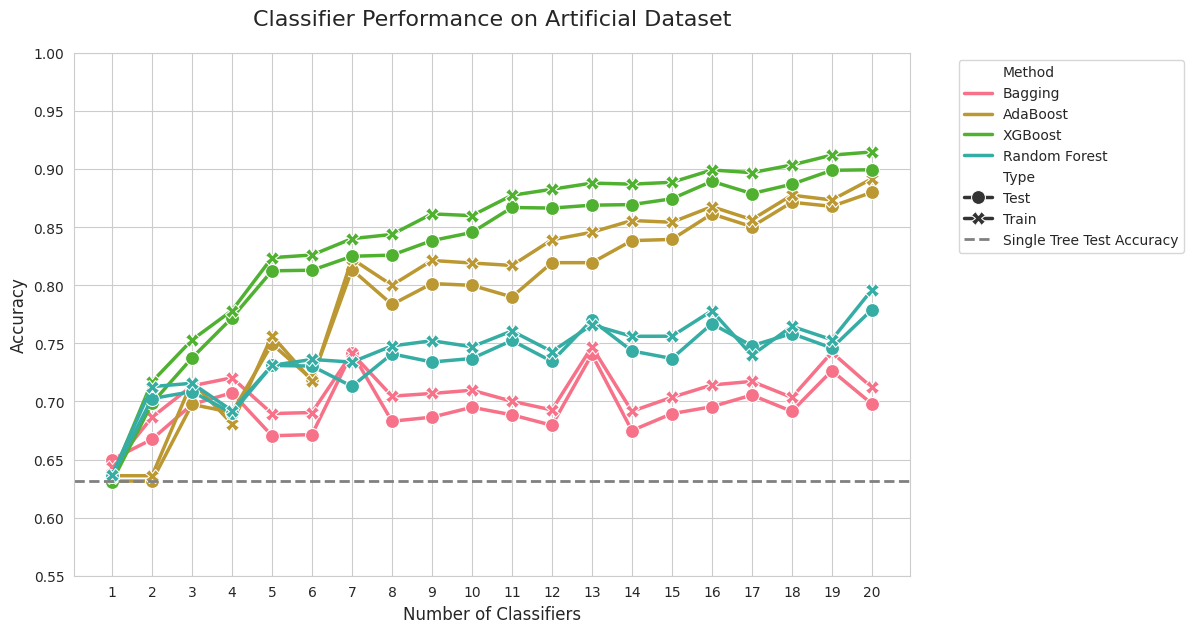

In [20]:
data_artificial = eval_classifiers(
    num_classifiers=20, 
    max_depth=2, 
    X_train=X_artificial_train, 
    X_test=X_artificial_test, 
    y_train=y_artificial_train, 
    y_test=y_artificial_test
    )
plot_data(data_artificial)
plt.title('Classifier Performance on Artificial Dataset', fontsize=16, pad=20)
plt.ylim([0.55, 1])
plt.show()

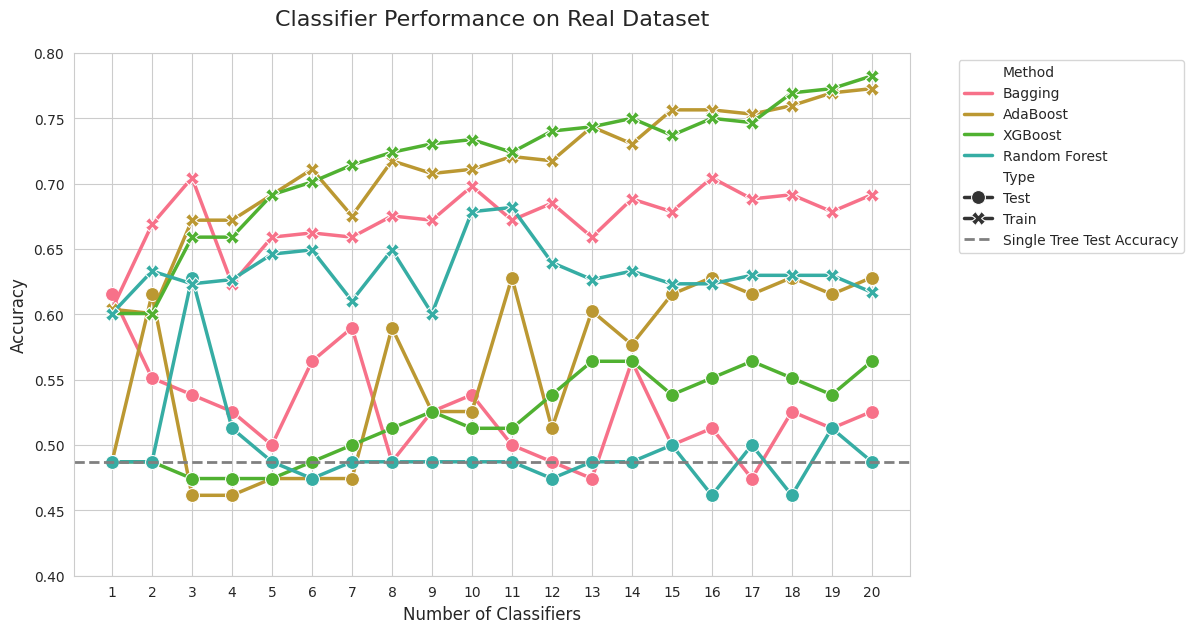

In [33]:
data_real = eval_classifiers(
    num_classifiers=20, 
    max_depth=2, 
    X_train=X_real_train, 
    X_test=X_real_test, 
    y_train=y_real_train, 
    y_test=y_real_test
    )
plot_data(data_real)
plt.title('Classifier Performance on Real Dataset', fontsize=16, pad=20)
plt.ylim([0.4, 0.8])
plt.show()